In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

There are multiple sources of financial data, I chose 'yahoofinance' for the sake of simplicity. The whole data set goes from 2015 and 2025, 70% will be used for training, 15% for validation and 15% for a final prediction.

YF.download() has changed argument auto_adjust default to True


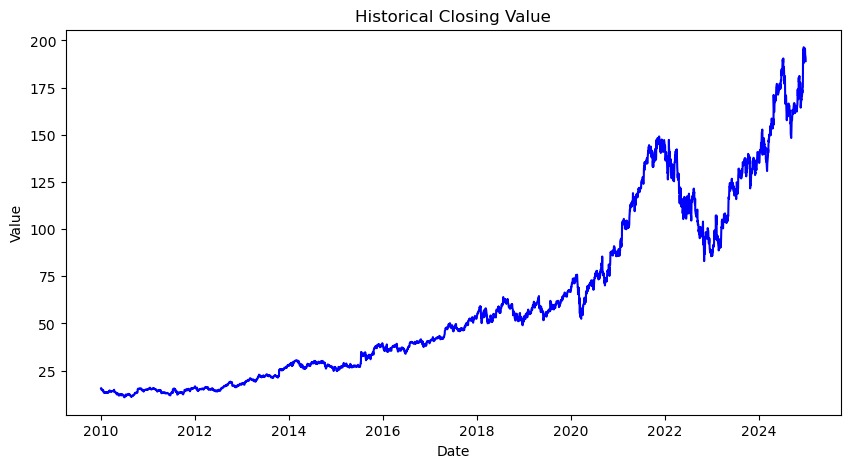

In [2]:
# Data pre-processing

data = yf.download("GOOGL", start="2010-01-01", end="2025-01-01", progress=False)
data = data[["Close"]]
data.ffill(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(data["Close"], color="blue")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Historical Closing Value")
plt.show()

Scaling the data is a standard practice, it makes results more stable and consistent. Usually, each is projected (linearly) to [0,1] where the minimum value goes to zero and the maximum one goes to 1. However, using the same scaling process for both training and validation/test data can leak information from one set to the other, making results less reliable. Thus, the scalig process is done with respect to the training set only, meaning, all data is transform with respect to the max and min of the trainning set, not the entire dataset. Finally, we will get the inputs, which are sequences of 60 values, and the output will be the next value (60 values to predict the next one).  

In [3]:
# Splitting and scaling



from sklearn.preprocessing import MinMaxScaler

train_size = int(len(data["Close"])*0.7)
val_size = int(len(data["Close"])*0.15)
test_size = int(len(data["Close"])*0.15)

train_data = data["Close"][:train_size]
val_data = data["Close"][train_size:train_size+val_size]
test_data = data["Close"][train_size+val_size:]

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):

        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

sequences_length = 100

X_train, y_train = create_sequences(train_scaled, sequences_length)
X_val, y_val = create_sequences(val_scaled, sequences_length)
X_test, y_test = create_sequences(test_scaled, sequences_length)

Next, we deifne the architecture we are going to use. We will code and compare 2 models: LSTM and GRU. Both of them tend to perform in a simlar way. However, the later has a simpler structure, which makes it faster.

In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, GRU

In [ ]:
# Parameters

early_stopping = EarlyStopping(monitor="val_loss", patience=10)
units = 50
d = 25
p = 0.3
learning_rate = 0.0005

optimizer_lstm = Adam(learning_rate=learning_rate)
optimizer_gru = Adam(learning_rate=learning_rate)

# LSTM 

model_lstm = Sequential([
    Input(shape=(sequences_length,1)),
    LSTM(units, return_sequences=True),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(1)
])

model_gru = Sequential([
    Input(shape=(sequences_length,1)),
    GRU(units, return_sequences=True),
    Dropout(p),
    GRU(units, return_sequences=False),
    Dropout(p),
    Dense(1)
])

model_lstm.compile(optimizer=optimizer_lstm, loss = "mean_squared_error")
model_gru.compile(optimizer=optimizer_gru, loss= "mean_squared_error")

model_lstm.summary()
model_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LSTM Training

history_lstm = model_lstm.fit(X_train, y_train,
                              validation_data = (X_val, y_val), epochs = 150,
                              batch_size = 32)
#, callbacks = [early_stopping]

Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0272 - val_loss: 0.0899
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0039 - val_loss: 0.0441
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0037 - val_loss: 0.0514
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0030 - val_loss: 0.0438
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0027 - val_loss: 0.0615
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0027 - val_loss: 0.0741
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0025 - val_loss: 0.0670
Epoch 8/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0024 - val_loss: 0.0463
Epoch 9/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0021 - val_loss: 0.0634
Epoch 10/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0021 - val_loss: 0.0627
Epoch 11/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0024 - val_loss: 0.0653
Epoch 12/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0

In [ ]:
history_gru = model_gru.fit(X_train, y_train, 
                            validation_data = (X_val,y_val), epochs = 150,
                            batch_size = 32)
#, callbacks = [early_stopping]

Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0458 - val_loss: 0.0122
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0037 - val_loss: 0.0081
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0030 - val_loss: 0.0157
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0025 - val_loss: 0.0151
Epoch 8/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 9/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 10/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0020 - val_loss: 0.0134
Epoch 11/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 12/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0

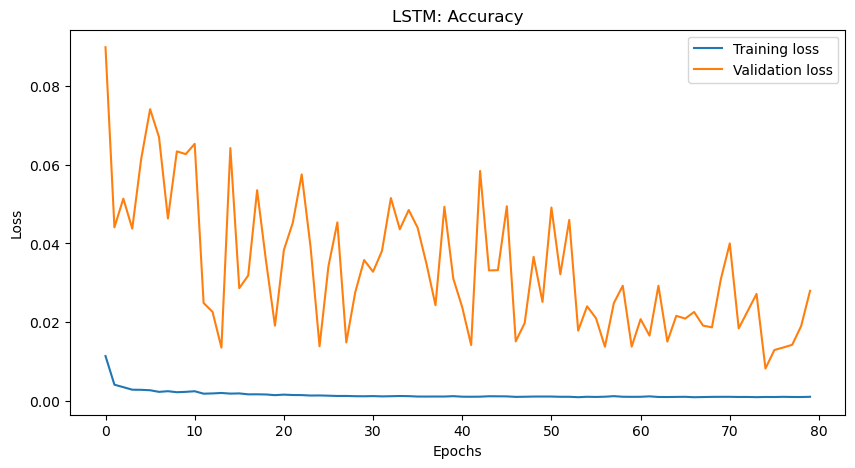

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history["loss"], label = "Training loss")
plt.plot(history_lstm.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM: Accuracy")
plt.legend()
plt.show()

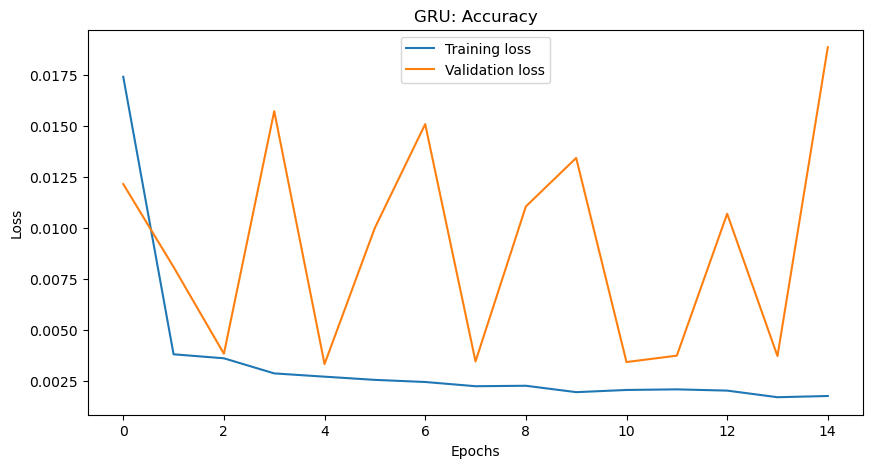

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history_gru.history["loss"], label = "Training loss")
plt.plot(history_gru.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GRU: Accuracy")
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


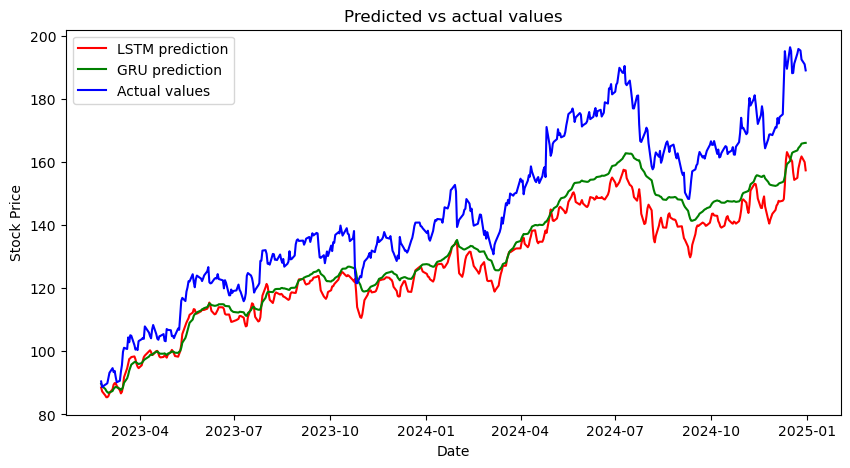

In [11]:
# Prediction on the test set

y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

test_dates = data.index[train_size+val_size+sequences_length:]

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.plot(test_dates, y_pred_lstm, label = "LSTM prediction", color = "red")
plt.plot(test_dates, y_pred_gru, label = "GRU prediction", color = "green")
plt.plot(test_dates, y_test_rescaled, label = "Actual values", color = "blue")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Predicted vs actual values")
plt.show()
